In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Import Data

In [2]:
# data = pd.read_csv('TANKTEMP092_098.txt',delimiter="\t", header=None, names=["date", "value"])
data = pd.read_csv('TANKTemp060_098.csv',sep=",", header=None, names=["date", "value"])

In [3]:
data.head()

,date,value
0,2015-060-00:00:30.114,18.744939
1,2015-060-00:00:30.882,18.744900
2,2015-060-00:02:38.114,18.785425
3,2015-060-00:02:38.882,18.785400
4,2015-060-00:04:46.114,18.785425


In [4]:
data.shape

(32122, 2)

# Data Engineering

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32122 entries, 0 to 32121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    32122 non-null  object 
 1   value   32119 non-null  float64
dtypes: float64(1), object(1)
memory usage: 502.0+ KB


In [6]:
data[data.isna().any(axis=1)]

,date,value
1571,2015-061-13:54:54.882,NaN
3794,2015-064-01:51:42.875,NaN
25868,2015-090-03:26:38.882,NaN


In [7]:
data = data.dropna()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32119 entries, 0 to 32121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    32119 non-null  object 
 1   value   32119 non-null  float64
dtypes: float64(1), object(1)
memory usage: 752.8+ KB


In [9]:
# reset index after dropping rows 
data = data.reset_index(drop=True)

In [10]:
data['StandardTime']=0
data.head()

,date,value,StandardTime
0,2015-060-00:00:30.114,18.744939,0
1,2015-060-00:00:30.882,18.744900,0
2,2015-060-00:02:38.114,18.785425,0
3,2015-060-00:02:38.882,18.785400,0
4,2015-060-00:04:46.114,18.785425,0


In [11]:
import calendar
import datetime

for i in range(len(data)):
    dd=data['date'][i].split('-')
    yy=int(dd[0])
    jd=int(dd[1])
    sec=dd[2].split(':')
    ss=sec[2][:-4]
    mm=sec[2][-3:]
    month = 1
    day = 0
    while jd - calendar.monthrange(yy,month)[1] > 0 and month <= 12:
        jd = jd - calendar.monthrange(yy,month)[1]
        month = month + 1

    data['StandardTime'][i]=datetime.datetime(yy, month, jd, int(sec[0]),int(sec[1]),int(ss),int(mm)*1000)

In [12]:
import calendar
import datetime

for i in range(len(data)):
    dd=data['date'][i].split('-')
    yy=int(dd[0])
    jd=int(dd[1])
    sec=dd[2].split(':')
    ss=sec[2][:-4]
    mm=sec[2][-3:]
    month = 1
    day = 0
    while jd - calendar.monthrange(yy,month)[1] > 0 and month <= 12:
        jd = jd - calendar.monthrange(yy,month)[1]
        month = month + 1

    data['StandardTime'][i]=datetime.datetime(yy, month, jd, int(sec[0]),int(sec[1]),int(ss),int(mm)*1000)

In [13]:
data.head()

,date,value,StandardTime
0,2015-060-00:00:30.114,18.744939,2015-03-01 00:00:30.114000
1,2015-060-00:00:30.882,18.744900,2015-03-01 00:00:30.882000
2,2015-060-00:02:38.114,18.785425,2015-03-01 00:02:38.114000
3,2015-060-00:02:38.882,18.785400,2015-03-01 00:02:38.882000
4,2015-060-00:04:46.114,18.785425,2015-03-01 00:04:46.114000


In [14]:
data_std = data.copy()
data_std.head()

,date,value,StandardTime
0,2015-060-00:00:30.114,18.744939,2015-03-01 00:00:30.114000
1,2015-060-00:00:30.882,18.744900,2015-03-01 00:00:30.882000
2,2015-060-00:02:38.114,18.785425,2015-03-01 00:02:38.114000
3,2015-060-00:02:38.882,18.785400,2015-03-01 00:02:38.882000
4,2015-060-00:04:46.114,18.785425,2015-03-01 00:04:46.114000


In [15]:
data_std.drop('date', axis=1, inplace=True)
data_std.head()

,value,StandardTime
0,18.744939,2015-03-01 00:00:30.114000
1,18.744900,2015-03-01 00:00:30.882000
2,18.785425,2015-03-01 00:02:38.114000
3,18.785400,2015-03-01 00:02:38.882000
4,18.785425,2015-03-01 00:04:46.114000


In [16]:
data_std.StandardTime = pd.to_datetime(data_std.StandardTime)
data_std = data_std.set_index('StandardTime')

In [17]:
data_std.head()

,value
StandardTime,
2015-03-01 00:00:30.114,18.744939
2015-03-01 00:00:30.882,18.744900
2015-03-01 00:02:38.114,18.785425
2015-03-01 00:02:38.882,18.785400
2015-03-01 00:04:46.114,18.785425


In [18]:
data_std.shape

(32119, 1)

Text(0.5, 0, 'Time')

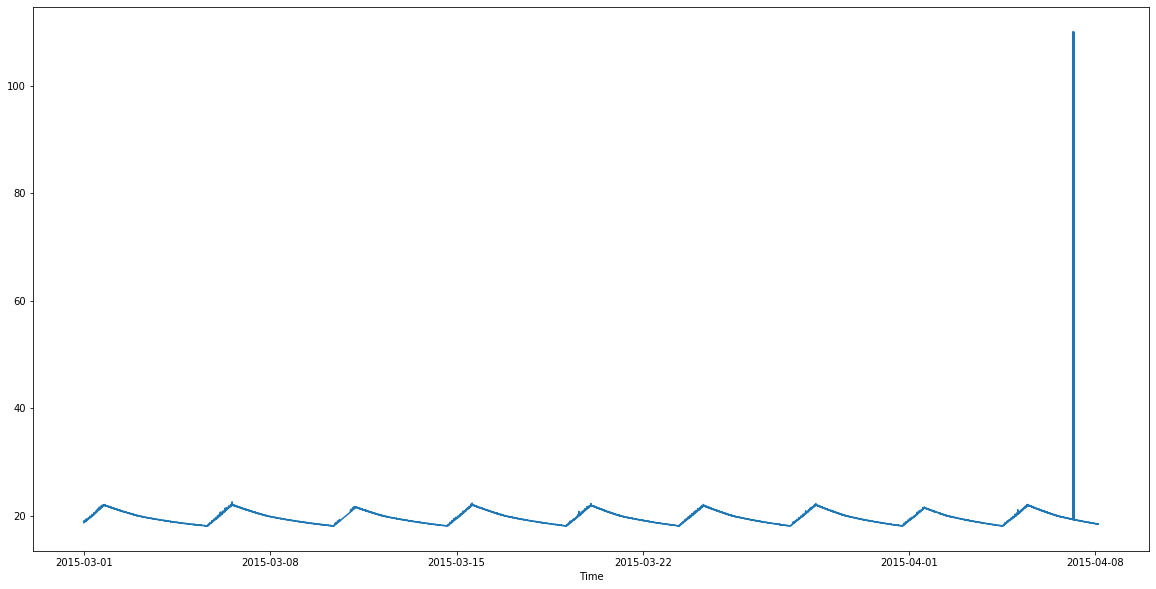

In [19]:
plt.figure(figsize=(20,10))
plt.plot(data_std)
plt.xlabel('Time')

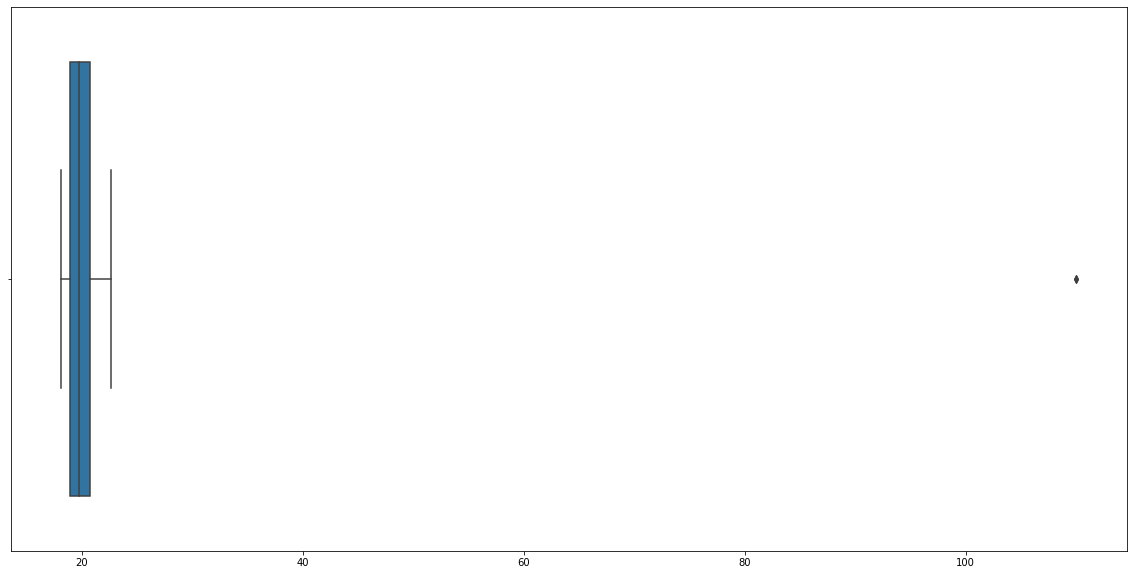

In [20]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.boxplot(data_std)

In [21]:
data_std['value'].max()

110.0

In [22]:
data_std.describe()

,value
count,32119.000000
mean,19.852985
std,1.293697
min,18.137652
25%,18.947368
50%,19.716599
75%,20.752688
max,110.000000


In [23]:
qt = data_std.quantile([.25,.5,.75])
qt

,value
0.25,18.947368
0.50,19.716599
0.75,20.752688


In [24]:
qt1 = data_std.quantile([.25])
qt1=float(qt1.to_numpy())
qt3 = data_std.quantile([.75])
qt3 = float(qt3.to_numpy())
print(qt1,qt3)
print(type(qt3))

18.947368 20.752688
<class 'float'>


In [25]:
# calculate max value of boxplot
max_box = qt3+(1.5*(qt3-qt1))
max_box

23.460668

In [26]:
# remove outlier
data_std.drop(data_std[data_std['value']>max_box].index, inplace=True)

In [27]:
data_std.head()

,value
StandardTime,
2015-03-01 00:00:30.114,18.744939
2015-03-01 00:00:30.882,18.744900
2015-03-01 00:02:38.114,18.785425
2015-03-01 00:02:38.882,18.785400
2015-03-01 00:04:46.114,18.785425


In [28]:
data_std.shape

(32117, 1)

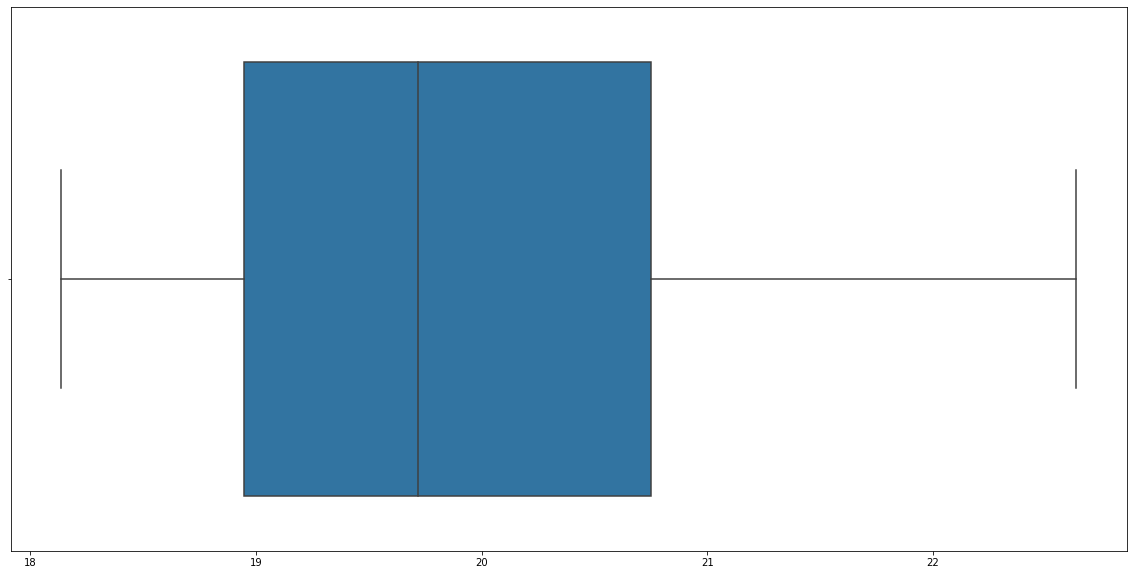

In [29]:
plt.figure(figsize=(20,10))
sns.boxplot(data_std)

Text(0.5, 0, 'Time')

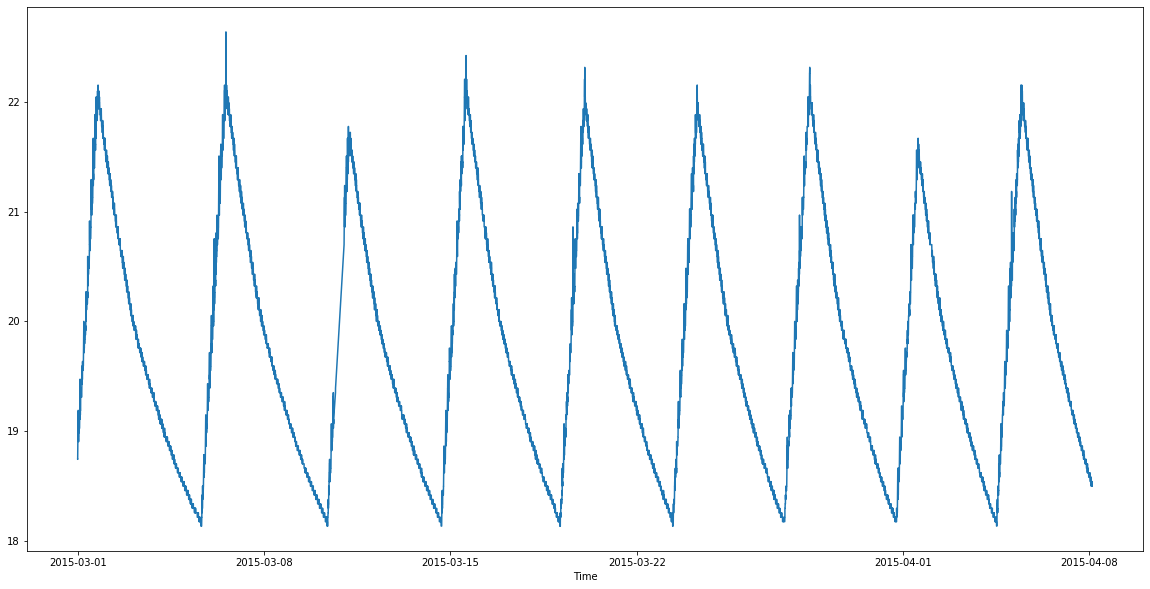

In [30]:
plt.figure(figsize=(20,10))
plt.plot(data_std)
plt.xlabel('Time')

# Predict

In [31]:
df_pre = data_std.copy()

In [32]:
df_pre.head()

,value
StandardTime,
2015-03-01 00:00:30.114,18.744939
2015-03-01 00:00:30.882,18.744900
2015-03-01 00:02:38.114,18.785425
2015-03-01 00:02:38.882,18.785400
2015-03-01 00:04:46.114,18.785425


In [33]:
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')

In [34]:
#Convert the dataframe to a numpy array
dataset = df_pre.values

In [35]:
dataset

array([[18.744939],
       [18.7449  ],
       [18.785425],
       ...,
       [18.54251 ],
       [18.54251 ],
       [18.502024]])

In [36]:
#Get the number of rows to train the model on
training_data_len = math.ceil( len(dataset) * .8 )

In [37]:
training_data_len

25694

In [38]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.13505026],
       [0.13504159],
       [0.14405366],
       ...,
       [0.09003351],
       [0.09003351],
       [0.08103011]])

In [39]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:training_data_len , :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []



for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])


In [40]:
print(train_data.shape)
print(x_train.shape)
print(y_train.shape)

(25694, 1)


AttributeError: 'list' object has no attribute 'shape'

In [41]:
train_data

array([[0.13505026],
       [0.13504159],
       [0.14405366],
       ...,
       [0.13505026],
       [0.13505026],
       [0.13505026]])

In [42]:
#Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

In [43]:
#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(25634, 60, 1)

In [44]:
x_train

array([[[0.13505026],
        [0.13504159],
        [0.14405366],
        ...,
        [0.18907041],
        [0.18907041],
        [0.18907041]],

       [[0.13504159],
        [0.14405366],
        [0.1440481 ],
        ...,
        [0.18907041],
        [0.18907041],
        [0.18907041]],

       [[0.14405366],
        [0.1440481 ],
        [0.14405366],
        ...,
        [0.18907041],
        [0.18907041],
        [0.18907041]],

       ...,

       [[0.14405366],
        [0.1440481 ],
        [0.15305705],
        ...,
        [0.13505026],
        [0.13505026],
        [0.13505026]],

       [[0.1440481 ],
        [0.15305705],
        [0.15305461],
        ...,
        [0.13505026],
        [0.13505026],
        [0.13505026]],

       [[0.15305705],
        [0.15305461],
        [0.14405366],
        ...,
        [0.13505026],
        [0.13505026],
        [0.13505026]]])

In [47]:
y_train

array([0.18907041, 0.18907041, 0.18908064, ..., 0.13505026, 0.13505026,
       0.13505026])

In [48]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [50]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [51]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
25634/25634 [==============================] - 1056s 41ms/step - loss: 2.7598e-04


In [53]:
#Create the testing data set
#Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [54]:
test_data.shape

(6483, 1)

In [55]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [56]:
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [57]:
x_test.shape

(6423, 60, 1)

In [58]:
#Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [59]:
#Get the root mean squared error (RMSE)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

0.037172289613703384

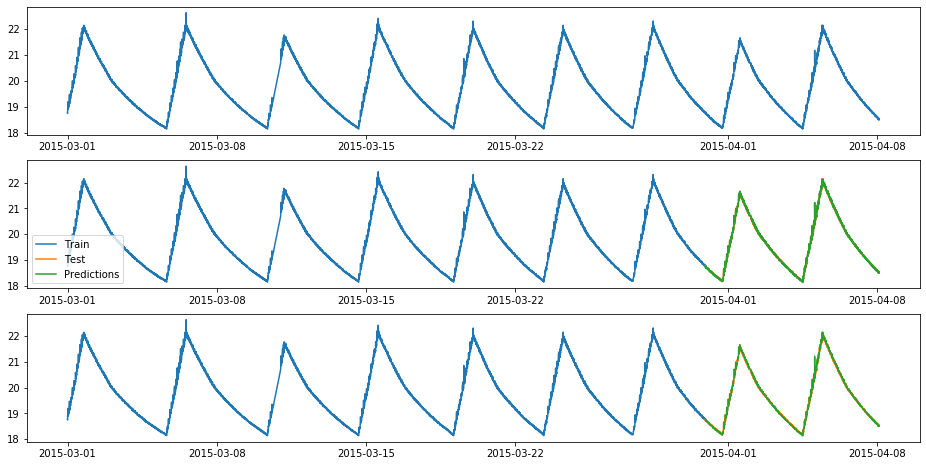

In [60]:
train = df_pre[:training_data_len]
valid = df_pre[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.subplot(3,1,1)
plt.plot(df_pre['value'])

plt.subplot(3,1,2)
plt.plot(train['value'])
plt.plot(valid[['value', 'Predictions']])
# plt.plot(train['Predictions'])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower left')

plt.subplot(3,1,3)
plt.plot(train['value'])
plt.plot(valid['value'])
plt.plot(valid['Predictions'],linewidth=1)
# plt.plot(valid[['value', 'Predictions']])



plt.show()

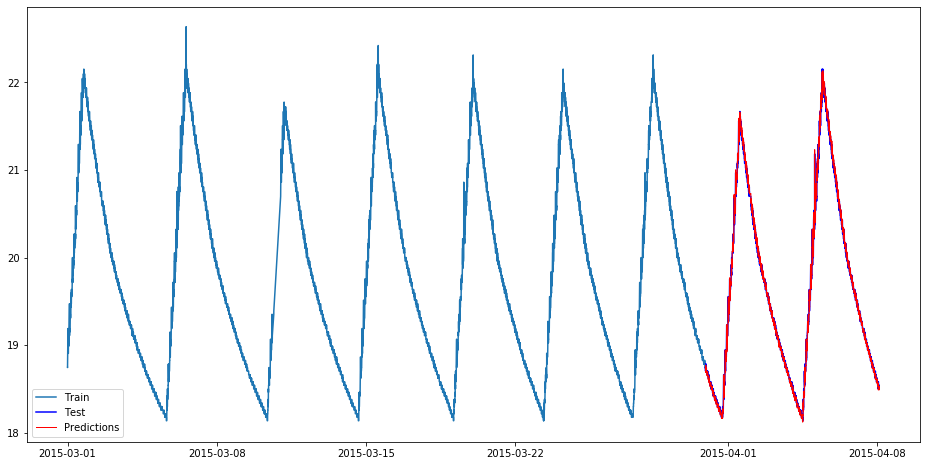

In [61]:
plt.figure(figsize=(16,8))
plt.plot(train['value'])
plt.plot(valid['value'],'b')
plt.plot(valid['Predictions'],'r',linewidth=1)
plt.legend(['Train', 'Test', 'Predictions'], loc='lower left')

In [62]:
valid

,value,Predictions
StandardTime,,
2015-03-30 22:39:26.114,18.744939,18.736504
2015-03-30 22:41:34.114,18.744939,18.736284
2015-03-30 22:43:42.114,18.744939,18.736099
2015-03-30 22:45:50.114,18.744939,18.735962
2015-03-30 22:47:58.114,18.744939,18.735872
...,...,...
2015-04-08 02:25:34.114,18.502024,18.488125
2015-04-08 02:27:42.114,18.502024,18.489023
2015-04-08 02:29:50.110,18.542510,18.489555


In [63]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6423 entries, 2015-03-30 22:39:26.114000 to 2015-04-08 02:34:06.114000
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   value        6423 non-null   float64
 1   Predictions  6423 non-null   float32
dtypes: float32(1), float64(1)
memory usage: 125.4 KB


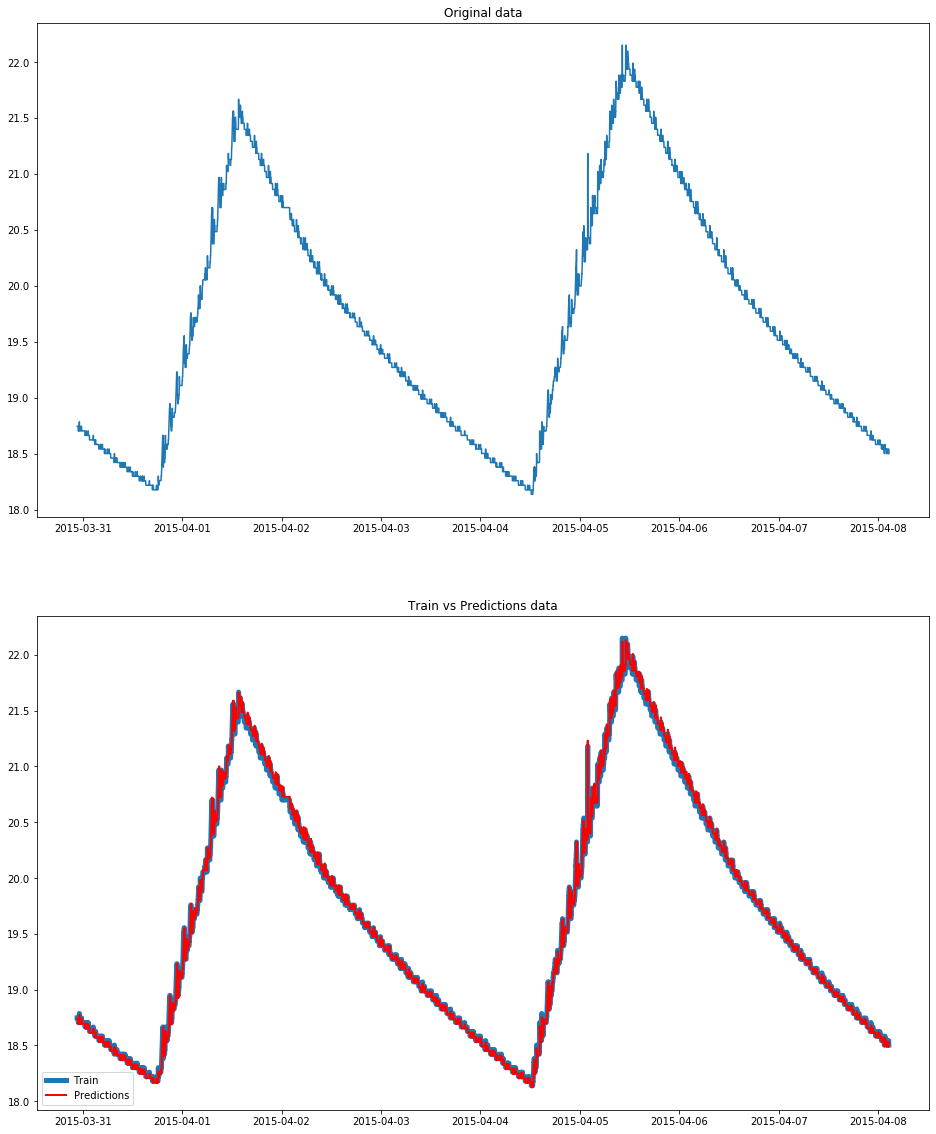

In [68]:
plt.figure(figsize=(16,20))
plt.subplot(2,1,1)
plt.plot(df_pre['value'][-len(valid):])
plt.title('Original data')

plt.subplot(2,1,2)
# plt.plot(train['value'][-len(valid):])
# plt.plot(valid[['value', 'Predictions'][-len(valid):]])
plt.plot(valid[['value']],linewidth=5)
plt.plot(valid[['Predictions']],'r',linewidth=2)
plt.title('Train vs Predictions data')
# plt.plot(train['Predictions'])
plt.legend(['Train', 'Predictions'], loc='lower left')

In [65]:
num_valid = 150
valid_plt = valid[-num_valid:]
valid

,value,Predictions
StandardTime,,
2015-03-30 22:39:26.114,18.744939,18.736504
2015-03-30 22:41:34.114,18.744939,18.736284
2015-03-30 22:43:42.114,18.744939,18.736099
2015-03-30 22:45:50.114,18.744939,18.735962
2015-03-30 22:47:58.114,18.744939,18.735872
...,...,...
2015-04-08 02:25:34.114,18.502024,18.488125
2015-04-08 02:27:42.114,18.502024,18.489023
2015-04-08 02:29:50.110,18.542510,18.489555


Text(0.5, 1.0, 'Predict vs Value of 150 data')

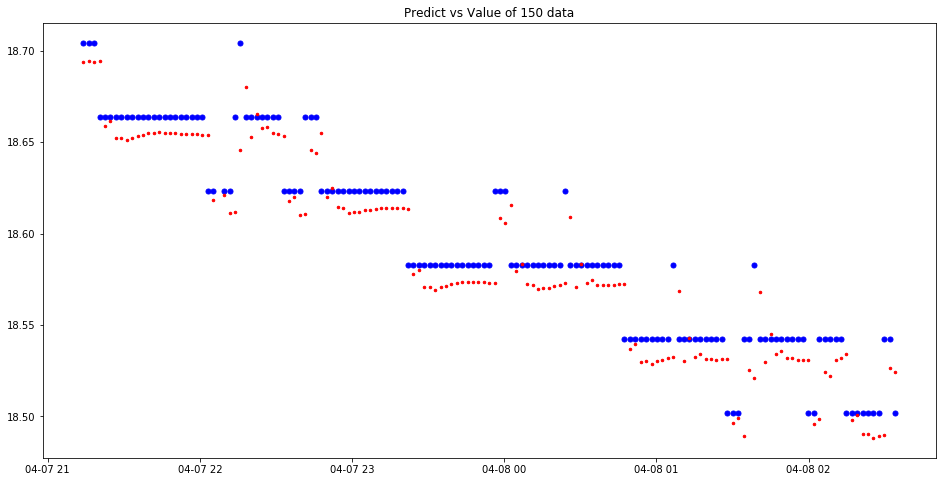

In [66]:
# plt.title("Predict vs Value", frontsize=14)
plt.figure(figsize=(16,8))
plt.plot(valid_plt[['value']],"bo",markersize =5, label="Value")
plt.plot(valid_plt[['Predictions']], 'r.',markersize =5, label="Predict")
plt.title("Predict vs Value of %d data" %num_valid)


# Ignore TestData

In [ ]:
#Create the testing data set
#Create a new array containing scaled values from index 1543 to 2002 
test_data1 = scaled_data[training_data_len - 60: , :]


#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
    
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

In [ ]:
test_data.shape

In [ ]:
dataset.shape

In [ ]:
datatest = data_std.copy()
datatest

In [ ]:
datatest['value'] = 24
datatest

In [ ]:
datatest = datatest.values
datatest

In [ ]:
test_data1 = scaled_data[training_data_len - 60: , :]
test_data1[:,:]=25


#Create the data sets x_test and y_test
x_test1 = []
y_test1 = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test1.append(test_data1[i-60:i, 0])
    
    
x_test1 = np.array(x_test1)

x_test1= np.reshape(x_test1, (x_test1.shape[0], x_test1.shape[1], 1 ))

predictions1 = model.predict(x_test1)
predictions1 = scaler.inverse_transform(predictions1)

rmse=np.sqrt(np.mean(((predictions1- y_test1)**2)))
rmse

In [ ]:
x_test1.shape

In [ ]:
predictions1

In [ ]:
datatestnp = np.array(datatest)

In [ ]:
datatestnp = np.reshape(datatestnp, (datatestnp.shape[0], datatestnp.shape[1], 1 ))

In [ ]:
datatestnp.shape

In [ ]:
predictions = model.predict(datatestnp)
predictions = scaler.inverse_transform(predictions)

# ARIMA with Statsmodels

In [ ]:
data_stat = data_std.copy()

In [ ]:
average = 1000

plt.figure(figsize=(16,5))
plt.plot(df_stat['value'])
plt.plot(df_stat.rolling(average).mean(),'red',linewidth=1)
plt.plot(df_stat.rolling(average).std(),linewidth=1)
plt.plot(df_stat.ewm(average).mean(),'lime',linewidth=1)
# data_stat.rolling(average).mean().plot(la)

plt.title(str(average)+' data simple moving average')
plt.legend(['value', str(average)+ ' SMA', str(average)+' STD',str(average)+ ' EMA'], loc='mid left')

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(df_stat.rolling(average).std(),linewidth=1)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
decomp = seasonal_decompose(data_stat,model='multiplicative', freq = 100)
fig = decomp.plot()
fig.set_size_inches(15,8)

In [ ]:
decomp = seasonal_decompose(data_stat,model='additive', freq =100)
fig = decomp.plot()
fig.set_size_inches(15,8)

In [ ]:
sig = data_stat['value'].rolling(window=100).mean()[:len(data_stat)].values

In [ ]:
plt.plot(sig)

In [ ]:
decomposed = sm.tsa.seasonal_decompose(sig, freq=4)

In [ ]:
sig

## Distribution 

In [ ]:
sns.distplot(data_std['value'],bins=10)

In [ ]:
data_rd = data_std.sample(frac=.1, random_state=20)
data_rd

In [ ]:
data_rd.shape

In [ ]:
sns.distplot(data_rd['value'],bins=10)

In [ ]:
plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
sns.distplot(data_std['value'],bins=10)
plt.title('Original data')
plt.subplot(2,2,2)
sns.distplot(data_rd['value'],bins=10)
plt.title('Random data')

In [ ]:
data_rd

In [ ]:
print(type(data_std))
print(type(data_rd))

In [ ]:
data_rd[data_rd.isna().any(axis=1)]

In [ ]:
data_rd['value']

In [ ]:
rd = data_rd.sort_index(axis=0)
rd

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(rd)

# data_rd.plot()

In [ ]:
df = data_std.copy()
df.head()

In [ ]:
test_size = 1000
train, test  = df[:-test_size], df[-test_size:]

In [ ]:
print('Train size = ' ,train.shape[0])
print('Test size = ' ,test.shape[0])

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [ ]:
n_input = 12
n_features = 1

generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)

model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator, epochs=10)

In [ ]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:, :], [[pred_list[i]]], axis=1)

In [ ]:
from pan

In [ ]:
# Normalization the dataset

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(df)

In [ ]:
dataset

In [ ]:
x = np.random.random(1024)
x = np.asarray(x, dtype=float)
N = x.shape[0]
n = np.arange(N)
k = n.reshape((N, 1))
M = np.exp(-2j * np.pi * k * n / N)


In [ ]:
x = np.random.random(1024)
# np.allclose(dft(x), np.fft.fft(x))


In [ ]:
x

In [ ]:
M

In [ ]:
plt.plot(M.real)

In [ ]:
M.real.shape

In [ ]:
from scipy.fftpack import fft 
f=fft(x)


In [ ]:
df_fft= np.array(data_std)

In [ ]:
df_fft

In [ ]:
df_fft1 = np.fft.fft(df_fft)
df_fft1

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(f,linewidth=1)

In [ ]:
from scipy.fft import fft
# Number of sample points
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(16,8))
plt.plot(xf,2.0/N * np.abs(yf[0:N//2]),linewidth=1)
plt.grid()
plt.show()

In [ ]:
x